## 설명 가능한 딥러닝 모델
: 예시로 딥러닝으로 알츠하이머형 치매 여를 판단하는 실험은 상당히 높은 정확도를 보인다. 하지만 실제 의료 현장에서 환자에게 딥러닝이 그렇다고 한다고 얘기할 수 없다. 딥러닝의 판단 결과를 설명하는 일도 쉽지 않다. 다차원 입력으로 인한 계산의 복잡성, 드러나지 않는 은닉층 등 그 중간과정을 유추해 내기 어렵기 때문. 

### 1. 딥러닝의 결과를 설명하는 방법
: 설명이 가능한 딥러닝 : Explainable AL (XAI)
- 예측의 근거를 설명해준다. 예로 이미지를 이용해 이름이나 물건의 종류를 맞히는 모델을 만들었다면, 이미지의 어디를 보고 왜 그런 판단을 했는지 설명하는 또 다른 그림을 그려낸다. 

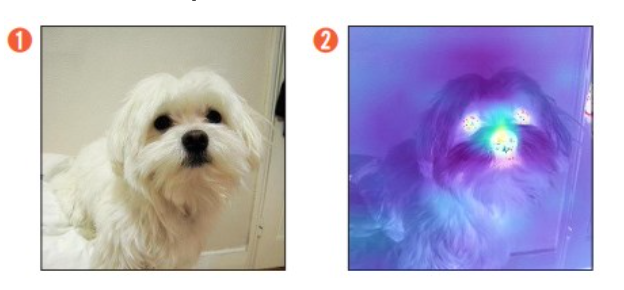

    - 색이 밝을수록 예측에 많은 기여를 했다는 것이고 파란색에 가까울수록 기여가 적다고 본다.
    - 그림을 보면 이 모델이 말티즈를 구분할 때 주로 눈과 코를 본다는 것을 알 수 있다. ==> 사용자에게 이 사진을 말티즈로 예측한 근거가 눈과 코라고 설명할 수 있다.

딥러닝의 결과를 설명해 주는 방법 중 현재 널리 사용되는 것은 크게 2가지
- (1) 딥러닝 중간 과정에서 나온 특징 맵을 이용 : Class Activation Map (CAM)

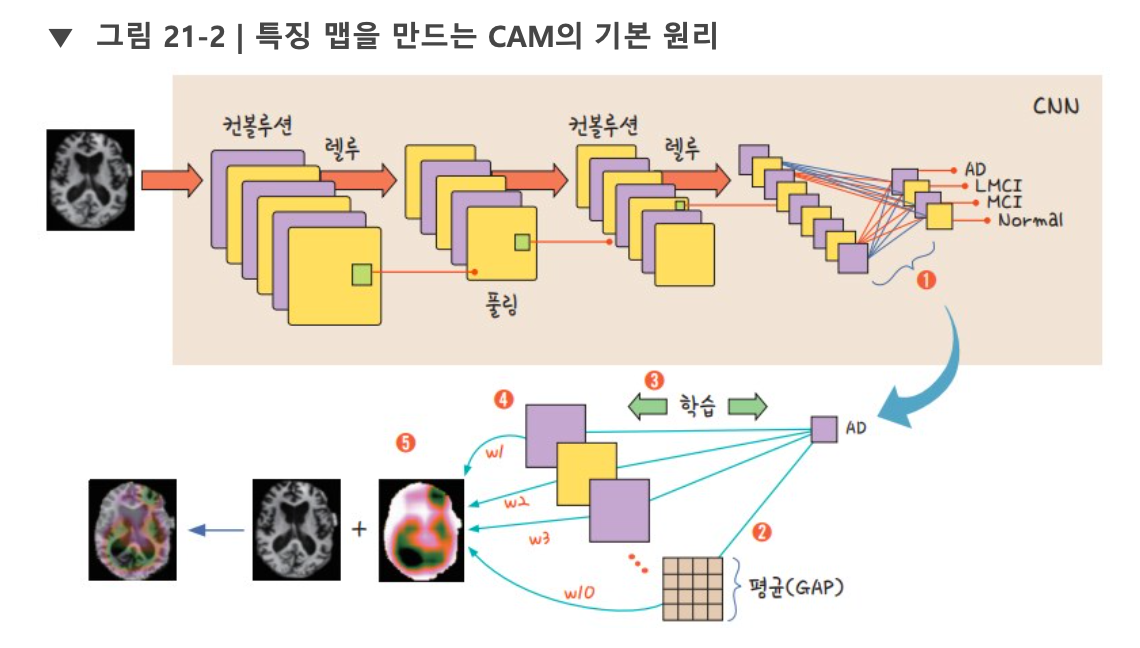

- (2) 일부를 가리면서 가려진 부분이 결과에 얼마나 영향을 미치는지 계산하는 방식 : 마스크 방식 또는 오클루전(폐쇄성 민감도 - Occlusion Sensitivity)

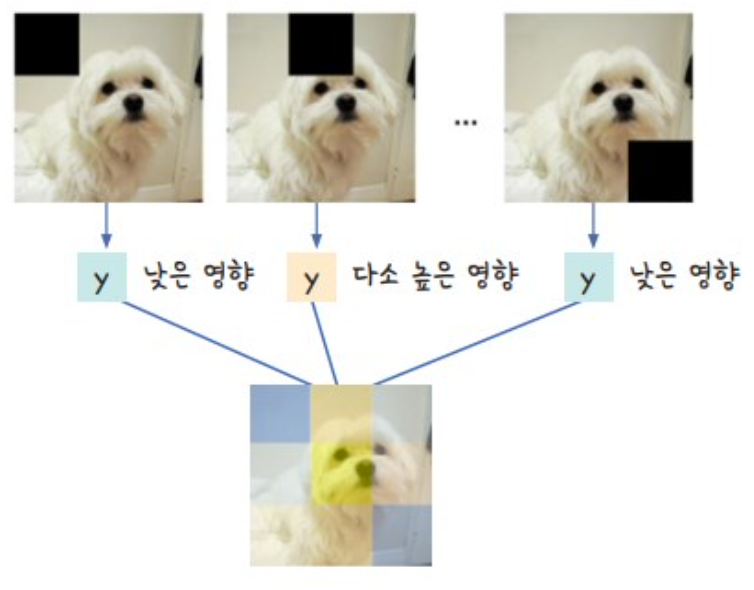


#### (1) CAM
- CAM의 원리를 살펴보기 위해 컨볼루션 신경망(CNN)에 대해 생각해보자
- 컨볼루션 신경망에서는 입력데이터가 컨볼루션, 풀링 레이어들에 통과시켜 입력된 2D이미지들을 1차원 배열로 축소시킨다. 이 과정에서 공간 정보의 손실이 발생할 수 밖에 없고 이를 해소하기 위해 컨볼루션 신경망이 사용된다. 컨볼루션 신경망 내부의 레이어들을 하나씩 거쳐 마지막 예측 단계까지 온 데이터들(중간맵)은 입력 데이터의 속성을 잘 간직하고 있다.
- 위 그림에서 보이는 것과 같이 데이터를 1차원으로 축소시키는 단계 직전에 그때까지 만들어진 중간맵들을 따로 모은 후(1) 그 중간 맵들 각각으로부터 평균값(Golbal Max Pooling, GAP - 중간맵 안에 들어있는 모든 값의 평균)을 모은다(2). 이 평균값과 최종 예측 사이에서 한번 더 학습(3). 그러면 어떤 중간 맵이 최종 결정에 큰 역할을 했는지 알려주는 가중치(4)를 얻게 된다.
- 이 가중치를 각 중간맵에 곱해 중요한 중간맵은 가중하고 불필요한 중간 맵은 자연스럽게 없애면서 특징맵(5)을 만들어 내는 것이 ==> CAM

- 같은 원리지만 평균값을 계산하기 위해 모델의 구조를 바꾸어야하는 번거로움을 피하고자 평균갑 대신 기울기를 이용 ==> 그래디언트 CAM (Gradient CAM)

### 2. 설명 가능한 딥러닝의 실행

필요한 라이브러리 install
- pip install tf-explain
- pip install opencv-python

In [2]:
# XAI 알고리즘을 불러오는 부분
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

2023-08-18 10:11:42.963619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# 이미지를 불러와 보여 주는 데 쓰는 라이브러리
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

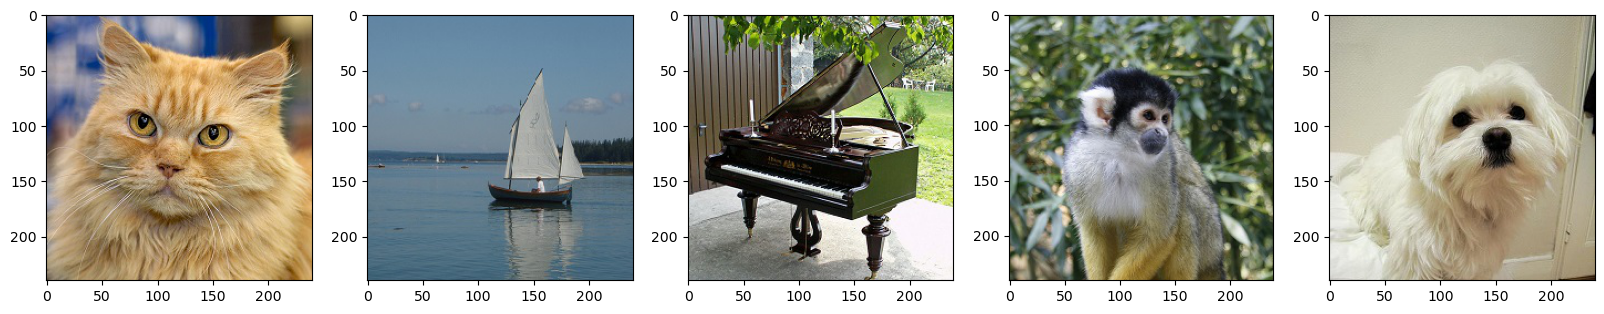

In [4]:
# 원본 이미지가 들어갈 리스트
orgn_images = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣는다
for img_path in glob.glob('../data/img/*_0.jpg'):
    orgn_images.append(mpimg.imread(img_path))

# 보여질 이미지의 크기
plt.figure(figsize = (20,20))

# 원본 이미지를 보이게 하기
for i, image_o in enumerate(orgn_images):
    plt.subplot(5,5,i+1)
    plt.imshow(image_o)

In [5]:
# 사전에 학습된 딥러닝 모델 불러오기
model = VGG16(weights = 'imagenet', include_top = True)

# 원본 이미지에 이름과 Imagenet에서의 해당 이미지 인데스
input_list = ['maltese', 'persian_cat', 'squirrel_monkey', 'grand_piano', 'yawl']
imagenet_index = ['153', '283', '382', '579', '914']

553467096/553467096 [==============================] - 105s 0us/step


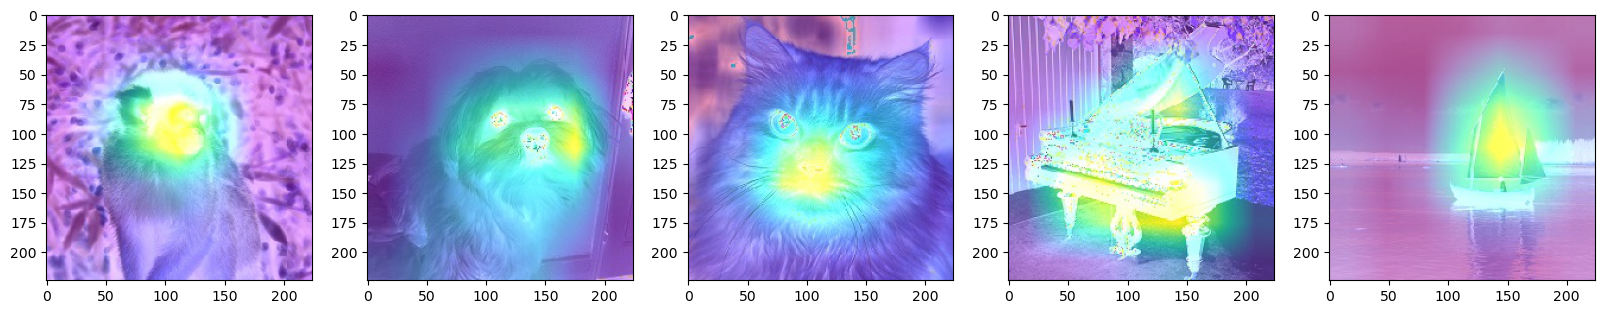

In [13]:
#그레디언트 CAM 알고리즘 선택
explainer = GradCAM()

# 그래디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트
images_cam = []

# 그래디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정
    img = load_img('../data/img/{}_0.jpg'.format(l), target_size = (224, 224))
    img = img_to_array(img)
    data = ([img], None)
    # 그래디언트 CAM 이 실행되는 부분
    grid = explainer.explain(data, model, int(i))
    # 실행 후 저장되는 이름
    explainer.save(grid, '.', '../data/img/{}_cam.jpg'.format(l))
# 그래디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분
plt.figure(figsize = (20,20))

for img_path in glob.glob('../data/img/*_cam.jpg'):
    images_cam.append(mpimg.imread(img_path))
    
for i, images_c in enumerate(images_cam):
    plt.subplot(5,5,i+1)
    plt.imshow(images_c)


In [14]:
# 오클루젼 알고리즘 선택
explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트
images_occl = []

# 패치 크기 설정
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('../data/img/{}_0.jpg'.format(l), target_size = (224, 224))
    img = img_to_array(img)
    data = ([img], None)
    # 패치크기 설정 추가
    grid = explainer.explain(data, model, int(i), patch_size)
    explainer.save(grid, '.', '../data/img/{}_occ1.jpg'.format(l))

2/2 [==============================] - 13s 2s/step


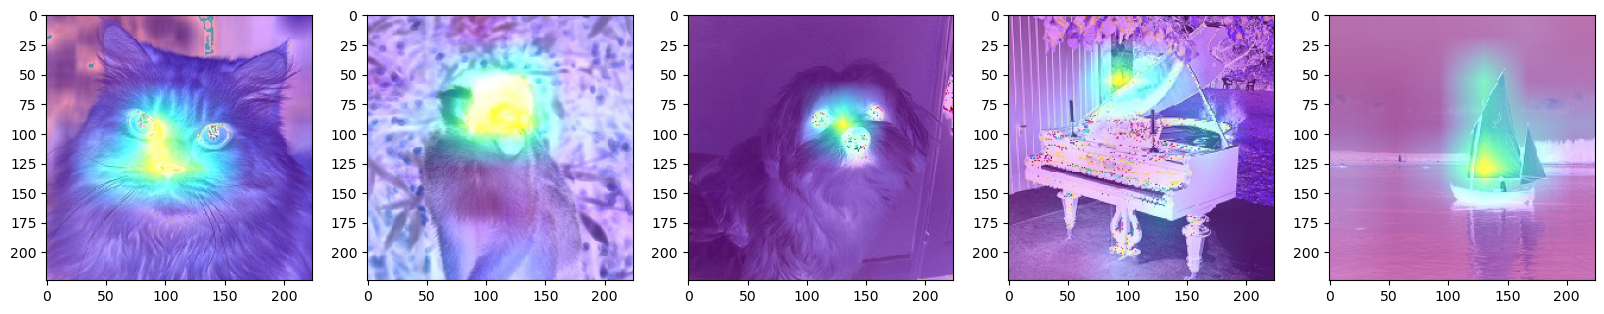

In [15]:
#오클루전 알고리즘이 적용된 이미지를 불러오는 부분
plt.figure(figsize = (20,20))

for img_path in glob.glob('../data/img/*_occ1.jpg'):
    images_occl.append(mpimg.imread(img_path))
    
for i, images in enumerate(images_occl):
    plt.subplot(5,5,i+1)
    plt.imshow(images)